In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from load_example_model_grid import load_MOM6_zint_heat_budget
grid = load_MOM6_zint_heat_budget()
ds = grid._ds

# Thermdynamic constants used in Boussinesq heat budget
rho0 = 1035. # kg/m^3
Cp = 3992. # J/kg/K

File 'MOM6_global_example_vertically_integrated_heat_budget_v0_0_6.nc' already exists at ../data/MOM6_global_example_vertically_integrated_heat_budget_v0_0_6.nc. Skipping download.


In [15]:
from sectionate import Section, join_sections
from regionate import BoundedRegion

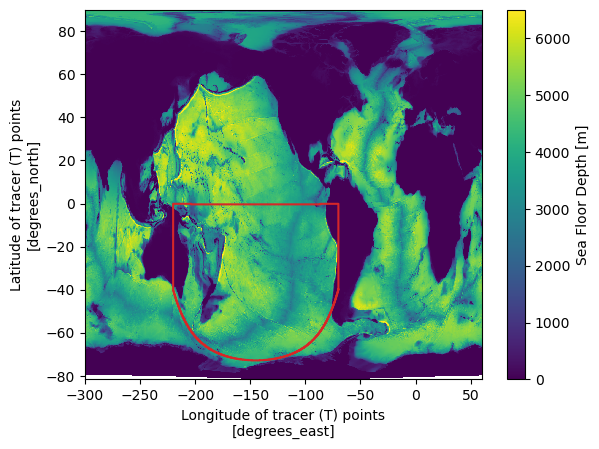

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

south_pacific_boundaries = [
    Section("southern", [(-220, -40),(-70, -40)]),
    Section("western",  [(-220, -40),(-220,  0)]),
    Section("northern", [(-220,   0),(-70,   0)]),
    Section("eastern",  [(- 70,   0),(-70, -40)])
]

section = join_sections("south pacific", *south_pacific_boundaries)
region = BoundedRegion(section, grid)

ds.deptho.plot(x="geolon", y="geolat")
plt.plot(region.lons_c, region.lats_c, color="w")

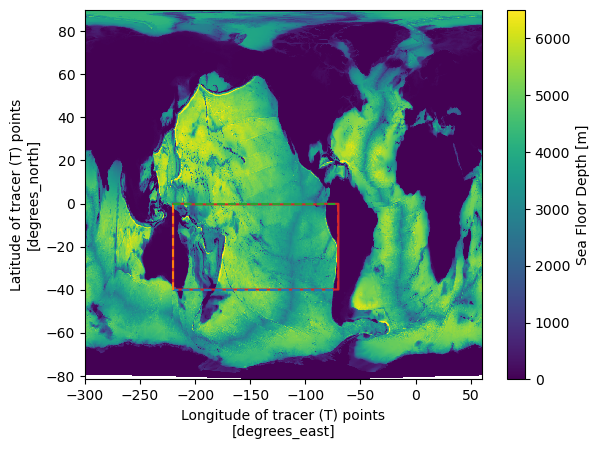

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

south_pacific_boundaries = [
    Section("southern", [(lon, -40) for lon in np.arange(-220, -70, 5)]),
    Section("western",  [(-220, -40),(-220,  0)]),
    Section("northern", [(-220,   0),(-70,   0)]),
    Section("eastern",  [(- 70,   0),(-70, -40)])
]

section = join_sections("south pacific", *south_pacific_boundaries)
region = BoundedRegion(section, grid)

ds.deptho.plot(x="geolon", y="geolat")

# Plot boundary of the region
plt.plot(region.lons_c, region.lats_c, color="w")

# Plot each child section that makes up the bounded region
for child in region.children.values():
    plt.plot(child.lons_c, child.lats_c, linestyle="--")